# **Projet : Classification dans un contexte déséquilibré, une application à la fraude bancaire**

---


Dans le cadre du *Master 2 SISE*, nous avons suivi un cours de **fouille de données massives** dont le but était de nous apprendre à lier le big data et le data mining afin de réaliser des analyses sur des données volumineuses. Pour valider cette matière, nous devIons réaliser un projet qui consiste à classifier des données dans un contexte déséquilibré. 

Concernant les données, elles proviennent d'une grande enseigne de la distribution ainsi que d'organismes bancaires (Banque de France et FNCI). Chaque ligne représente une transaction par chèque dans un magasin de l'enseigne. Le but est de prédire la variable **FlagImpaye** qui prend comme valeur 0 si la transaction a été acceptée et 1 si elle a été refusée. 

Dans un premier temps, nous allons découvrir les données en réalisant des statistiques descriptives pour mieux comprendre la situation et les enjeux, puis, dans un second temps, nous allons tester plusieurs modèles de machine learning afin de prédire au mieux la variable cible. 

#  I. Traitements préliminaires : import, statistiques descriptives et pré-traitements

## 1) Import des données et description

In [ ]:
#Importation des librairies
import pandas as pd

In [ ]:
#Importation du fichier de données
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lors de l'exploration du fichier, nous avons vu qu'il y a une ligne d'en-tête au milieu du fichier à la ligne 1 956 361. Lors de l'importation, nous avons donc décidé de supprimer cette ligne directement. 

In [ ]:
#Importation des données en supprimant la ligne d'en-tête au milieu du fichier
data = pd.read_csv("/content/drive/MyDrive/MASTER 2 SISE/M2_SISE_Fouille_donnees_massives/data/guillaume.txt",sep=";",decimal=",",
                   skiprows=[1956361])

In [ ]:
#Informations du fichier
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4646773 entries, 0 to 4646772
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisationCheque  int64  
 2   FlagImpaye                int64  
 3   Montant                   float64
 4   DateTransaction           object 
 5   CodeDecision              int64  
 6   VerifianceCPT1            int64  
 7   VerifianceCPT2            int64  
 8   VerifianceCPT3            int64  
 9   D2CB                      int64  
 10  ScoringFP1                float64
 11  ScoringFP2                float64
 12  ScoringFP3                float64
 13  TauxImpNb_RB              float64
 14  TauxImpNB_CPM             float64
 15  EcartNumCheq              int64  
 16  NbrMagasin3J              int64  
 17  DiffDateTr1               float64
 18  DiffDateTr2               float64
 19  DiffDateTr3               float64
 20  CA3TRetMtt              

Nous pouvons voir que, lors de l'importation, le transcryptage a plutôt été bien effectué par python. Cependant, nous devons changer le type de la variable "DateTransaction" afin de la mettre dans le format datetime. 

In [ ]:
# Description des données
data.describe()

,IDAvisAutorisationCheque,FlagImpaye,Montant,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
count,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06,4.646773e+06
mean,8.088216e+07,6.455017e-03,6.014214e+01,2.516043e-01,2.295272e-01,2.452963e-01,2.716444e-01,3.139046e+02,2.217686e+00,2.033179e+00,1.373319e-01,3.912727e+01,3.850640e+01,8.480311e+03,1.036989e+00,3.873620e+00,4.166527e+00,4.199614e+00,6.730030e+01,7.158162e+00,5.248595e+04
std,1.781519e+06,8.008340e-02,1.019927e+02,4.475876e-01,4.422162e-01,4.965438e-01,5.812737e-01,2.207225e+02,2.709370e+01,9.715521e+00,4.867118e-01,6.011574e+01,1.673441e+01,1.982303e+05,1.920397e-01,1.059257e+00,5.171843e-01,4.242342e-01,1.114365e+02,3.860036e+01,1.187262e+04
min,7.864304e+07,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-6.446148e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.703704e-04,7.754630e-04,1.000000e-02,0.000000e+00,1.822500e+04
25%,7.946082e+07,0.000000e+00,2.598000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.900000e+01,5.631127e-03,-1.481721e+00,1.185316e-03,2.223457e+01,2.875694e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,2.940000e+01,0.000000e+00,4.148500e+04
50%,8.029597e+07,0.000000e+00,4.412000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.870000e+02,1.096892e-02,1.636853e-01,1.728123e-03,3.433578e+01,3.681303e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.941000e+01,0.000000e+00,5.347800e+04
75%,8.217947e+07,0.000000e+00,7.304000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.320000e+02,4.344551e-02,7.354217e+00,5.157858e-03,4.658322e+01,5.088256e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,8.282000e+01,0.000000e+00,6.287700e+04
max,8.496640e+07,1.000000e+00,1.212600e+05,4.000000e+00,1.600000e+01,2.600000e+01,3.200000e+01,5.510000e+02,2.049888e+04,5.240133e+01,1.649094e+01,1.000000e+04,1.276970e+02,9.956167e+06,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.212600e+05,1.560000e+04,8.195800e+04


In [ ]:
# Dimension du fichier
data.shape

(4646773, 23)

Nous pouvons voir que nous avons énormement de données soit 4 646 773 lignes et 23 variables. La description des variables est présente dans le sujet. 

## 2) Pré-traitements des données

### 2.1 Transformation et suppression de variables

In [ ]:
#Suppression des variables non utiles à notre prédiction
data = data.drop(columns=['ZIBZIN', 'IDAvisAutorisationCheque'])

Nous avons supprimé les colonnes d'identifiant : identificiant bancaire ZIBZIN et l'identifiant du chèque IDAvisAutorisationCheque. Ces deux colonnes ne sont pas utiles aux modèles de prédiction par la suite. 

In [ ]:
#Transformation de la date en datetime
data['DateTransaction'] = pd.to_datetime(data['DateTransaction'])

In [ ]:
#Informations du fichier
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4646773 entries, 0 to 4646772
Data columns (total 21 columns):
 #   Column           Dtype         
---  ------           -----         
 0   FlagImpaye       int64         
 1   Montant          float64       
 2   DateTransaction  datetime64[ns]
 3   CodeDecision     int64         
 4   VerifianceCPT1   int64         
 5   VerifianceCPT2   int64         
 6   VerifianceCPT3   int64         
 7   D2CB             int64         
 8   ScoringFP1       float64       
 9   ScoringFP2       float64       
 10  ScoringFP3       float64       
 11  TauxImpNb_RB     float64       
 12  TauxImpNB_CPM    float64       
 13  EcartNumCheq     int64         
 14  NbrMagasin3J     int64         
 15  DiffDateTr1      float64       
 16  DiffDateTr2      float64       
 17  DiffDateTr3      float64       
 18  CA3TRetMtt       float64       
 19  CA3TR            float64       
 20  Heure            int64         
dtypes: datetime64[ns](1), float64(1

### 2.2 Vérification des valeurs manquantes

In [ ]:
data.count()

FlagImpaye         4646773
Montant            4646773
DateTransaction    4646773
CodeDecision       4646773
VerifianceCPT1     4646773
VerifianceCPT2     4646773
VerifianceCPT3     4646773
D2CB               4646773
ScoringFP1         4646773
ScoringFP2         4646773
ScoringFP3         4646773
TauxImpNb_RB       4646773
TauxImpNB_CPM      4646773
EcartNumCheq       4646773
NbrMagasin3J       4646773
DiffDateTr1        4646773
DiffDateTr2        4646773
DiffDateTr3        4646773
CA3TRetMtt         4646773
CA3TR              4646773
Heure              4646773
dtype: int64

Nous pouvons voir que toutes les variables sont complètes, il n'y a aucune valeur manquante. 

### 2.3 Analyse de la variable cible : FlagImpaye

Nous allons faire une analyse plus poussée de la variable cible afin de savoir sa distribution et ses caractéristiques. Elle est composée de deux modalités : 0 lorsque la transaction est acceptée et 1 lorsqu'elle est refusée. 

In [ ]:
# Nb de chèque accepté et refusé
print(data['FlagImpaye'].value_counts(normalize=True))

0    0.993545
1    0.006455
Name: FlagImpaye, dtype: float64


Il y a donc un fort déséquilibre entre les deux modalités. Nous pouvons voir que seulement 0.006% des transactions par chèque sont refusées dans cette enseigne. 

Nous sommes donc dans un cas désésquilibré c'est-à-dire qu'une classe est majoritaire sur l'autre, ici les transactions acceptées. Nous devons le prendre en compte dans la suite dans nos modèles de prédiction afin d'obtenir des résultats les plus fiables possibles. En effet, si nous ne le prenons pas en compte, nos interprétations peuvent être totalement fausses. 

# II Modèles de prédiction

Cette partie est concacrée à nos modèles de prédiction. Nous allons effectuer plusieurs modèles de prédiction, les évaluer et les comparer entre eux. 

Dans un premier temps, nous avons séparé nos données en échantillon d'apprentissage et échantillon de test. Puis, nous avons centré-réduit les variables explicatives afin de les mettre à la même échelle et pouvoir les comparer. Enfin, nous avons fait le choix de réaliser une méthode de rééchantillonnage SMOTE pour nos données. De ce fait, les données ne sont plus déséquilibrées et nous appliquons nos différents modèles de prédiction sur des données centrées-réduites et équilibrées.

Dans la suite, nous avons testé un modèle Gradient Boosting, un modèle K plus proches voisins, une régression logistique, un Random Forest et ....



## 1) Séparation des données en échantillons d'apprentissage et test et centrage-réduction des variables explicatives

### 1.1 Séparation des données en apprentissage et test


In [ ]:
# Vue des données 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4646773 entries, 0 to 4646772
Data columns (total 21 columns):
 #   Column           Dtype         
---  ------           -----         
 0   FlagImpaye       int64         
 1   Montant          float64       
 2   DateTransaction  datetime64[ns]
 3   CodeDecision     int64         
 4   VerifianceCPT1   int64         
 5   VerifianceCPT2   int64         
 6   VerifianceCPT3   int64         
 7   D2CB             int64         
 8   ScoringFP1       float64       
 9   ScoringFP2       float64       
 10  ScoringFP3       float64       
 11  TauxImpNb_RB     float64       
 12  TauxImpNB_CPM    float64       
 13  EcartNumCheq     int64         
 14  NbrMagasin3J     int64         
 15  DiffDateTr1      float64       
 16  DiffDateTr2      float64       
 17  DiffDateTr3      float64       
 18  CA3TRetMtt       float64       
 19  CA3TR            float64       
 20  Heure            int64         
dtypes: datetime64[ns](1), float64(1

In [ ]:
#Scindage en Train et Test selon les dates
Train = data[ (data['DateTransaction'] >= '2017-02-01') & (data['DateTransaction']<='2017-08-31') ]
Test = data[ (data['DateTransaction'] >= '2017-09-01') & (data['DateTransaction']<='2017-11-30') ]
print(Train.shape)
print(Test.shape)

(3888468, 21)
(737068, 21)


In [ ]:
#Suppression de la variable 'DateTransaction' et de Heure
Train = Train.drop(columns=['DateTransaction','Heure'])
Test = Test.drop(columns=['DateTransaction','Heure'])

In [ ]:
#Informations du fichier 
print(Train)
print(Test)

         FlagImpaye  Montant  CodeDecision  ...  DiffDateTr3  CA3TRetMtt   CA3TR
0                 0    20.00             1  ...          4.0       20.00    0.00
1                 0    20.00             1  ...          4.0       28.61    8.61
2                 0    57.64             1  ...          4.0       57.64    0.00
3                 0    54.29             0  ...          4.0       54.29    0.00
4                 0    26.90             1  ...          4.0       59.15   32.25
...             ...      ...           ...  ...          ...         ...     ...
3888463           0   137.90             0  ...          4.0      137.90    0.00
3888464           0    73.76             0  ...          4.0       73.76    0.00
3888465           0    61.21             0  ...          4.0       61.21    0.00
3888466           0    58.90             0  ...          4.0      304.50  245.60
3888467           0    24.99             0  ...          4.0       24.99    0.00

[3888468 rows x 19 columns]

In [ ]:
#Séparation en X et Y
XTrain = Train.iloc[:,1:21]
YTrain = Train.iloc[:,0]

XTest = Test.iloc[:,1:21]
YTest = Test.iloc[:,0]

print(XTrain.shape)
print(YTrain.shape)
print(XTest.shape)
print(YTest.shape)

(3888468, 18)
(3888468,)
(737068, 18)
(737068,)


In [ ]:
print(XTrain)
print(YTrain)

         Montant  CodeDecision  VerifianceCPT1  ...  DiffDateTr3  CA3TRetMtt   CA3TR
0          20.00             1               0  ...          4.0       20.00    0.00
1          20.00             1               0  ...          4.0       28.61    8.61
2          57.64             1               0  ...          4.0       57.64    0.00
3          54.29             0               1  ...          4.0       54.29    0.00
4          26.90             1               0  ...          4.0       59.15   32.25
...          ...           ...             ...  ...          ...         ...     ...
3888463   137.90             0               0  ...          4.0      137.90    0.00
3888464    73.76             0               0  ...          4.0       73.76    0.00
3888465    61.21             0               0  ...          4.0       61.21    0.00
3888466    58.90             0               0  ...          4.0      304.50  245.60
3888467    24.99             0               0  ...          4.0 

In [ ]:
print(XTest)
print(YTest)

         Montant  CodeDecision  VerifianceCPT1  ...  DiffDateTr3  CA3TRetMtt  CA3TR
3899362    60.00             0               0  ...     4.000000       60.00   0.00
3899363    25.00             0               0  ...     4.000000       25.00   0.00
3899364    32.00             0               0  ...     4.000000       32.00   0.00
3899365    20.88             0               0  ...     1.539155       92.39  71.51
3899366    20.21             0               0  ...     4.000000       20.21   0.00
...          ...           ...             ...  ...          ...         ...    ...
4636425    79.75             0               0  ...     4.000000       79.75   0.00
4636426     8.40             0               0  ...     4.000000        8.40   0.00
4636427    14.27             0               0  ...     4.000000       14.27   0.00
4636428    30.15             0               0  ...     5.000000       30.15   0.00
4636429    34.36             0               0  ...     5.000000       68.21

### 1.2 Centrage-réduction des variables explicatives

Nous allons centrer-réduire les variables explicatives. En effet, elles sont exprimées avec des échelles différentes ce qui rend leurs comparaisons compliquées. Nous allons standardiser l'échantillon d'apprentissage puis nous appliquons les mêmes paramètres (moyenne et écart-type) de l'échantillon train pour standardiser l'échantillon de test. 

In [ ]:
#Centrage-réduction 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
        
#transformation – centrage-réduction
XTrain = sc.fit_transform(XTrain)
XTest = sc.transform(XTest)

In [ ]:
#Vérification
print(XTrain)
print(XTest)

[[-0.41991517  1.49583656 -0.58291466 ... -0.45098926 -0.4551077
  -0.20275137]
 [-0.41991517  1.49583656 -0.58291466 ... -0.45098926 -0.37165145
   0.03877605]
 [-0.02203723  1.49583656 -0.58291466 ... -0.45098926 -0.09026526
  -0.20275137]
 ...
 [ 0.01569986 -0.63468624 -0.58291466 ... -0.45098926 -0.05566145
  -0.20275137]
 [-0.00871826 -0.63468624 -0.58291466 ... -0.45098926  2.30253508
   6.68681129]
 [-0.3671678  -0.63468624 -0.58291466 ... -0.45098926 -0.40673991
  -0.20275137]]
[[ 0.00290942 -0.63468624 -0.58291466 ... -0.45098926 -0.06738991
  -0.20275137]
 [-0.36706209 -0.63468624 -0.58291466 ... -0.45098926 -0.40664298
  -0.20275137]
 [-0.29306779 -0.63468624 -0.58291466 ... -0.45098926 -0.33879236
  -0.20275137]
 ...
 [-0.48048479 -0.63468624 -0.58291466 ... -0.45098926 -0.51064827
  -0.20275137]
 [-0.31262343 -0.63468624 -0.58291466 ...  1.95521654 -0.35672431
  -0.20275137]
 [-0.26812114 -0.63468624 -0.58291466 ...  1.95521654  0.01218917
   0.74680765]]


### 1.3 Méthode de réchantillonnage : SMOTE

Comme nous sommes dans le cas déséquilibré, nous avons fait le choix de rééchantillonner nos données. C'est une technique qui génére des échantillons synthétiques de manière automatique. Il y a deux méthodes : l'Oversampling qui augmente le nombre d'observations de la classe minoritaire ou l'Undersampling qui diminue le nombre d'observations de la classe majoritaire. Ces deux méthodes ont pour but d'obtenir un ratio classe minoritaire et classe majoritaire satisfaisant afin d'obtenir des résultats corrects et interprétables. 

Nous avons fait le choix d'utiliser une méthode d'Oversampling, SMOTE (Synthetic Minority Over-sampling Technique). Elle fonctionne en créant des échantillons synthétiques à partir de la classe minoritaire au lieu de créer de simples copies. C'est une méthode très connue et efficace.

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
XTrain, YTrain = oversample.fit_resample(XTrain, YTrain)

In [ ]:
# Nouvelles distributions des classes
print(YTrain.value_counts(normalize=True))

1    0.5
0    0.5
Name: FlagImpaye, dtype: float64


Nous pouvons voir que nos classes ont été équilibrées. Maintenant nous avons autant de transactions refusées que acceptées. Nous allons donc appliquer des algorithmes de machine learning sur nos nouvelles données réechantillonnées. 

## 2) Nos modèles de prédiction

### 2.1 Gradient Boosting

Nous avons décidé de tester un modèle Gradient Boosting sur nos données. En effet, nous avons effectué de nombreuses recherches et il en ressort que ce modèle semble adapté pour la détection de fraude dans des cas déséquilibré. C'est un algorithme supervisé qui a pour but de combiner les résultats d'un ensemble de modèles plus simples afin de fournir une meilleure prédiction au lieu d'effectuer uniquement un modèle. On peut gérer des problèmes de régression et de classification avec cette méthode. 

Nous allons utiliser XGBoost, une librairie de Python. XGBoost signifie eXtreme Gradient Boosting. Dans XGBoost, il y a un traitement parallèle qui est implémenté ce qui permet de réduire considérablement les calculs par rapport à GBM par exemple. C'est une implémentation optimisée de l’algorithme d’arbres de boosting de gradient.

In [ ]:
# Instanciation du modèle
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=1)

In [ ]:
# Entraînement du modèle sur les données d'apprentissage 
modele_xgbBoost = xgb.fit(XTrain,YTrain)

[20:38:34] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
# Prédiction sur nos données test
prediction_xgbBoost = modele_xgbBoost.predict(XTest)

NameError: ignored

In [ ]:
# Matrice de confusion
from sklearn import metrics
matrice_confusion = metrics.confusion_matrix(YTest,prediction_xgbBoost)
print(matrice_confusion)

In [ ]:
# Calcul du f1 score
f1_score_xgbBoost = metrics.f1_score(YTest, prediction_xgbBoost)
print(f1_score_xgbBoost)

La f1 mesure pour ce modèle est de 16%, ce qui est faible. Nous avons utilisé un modèle avec des variables centrées réduites et avec un rééchantillonnage afin d'équilibrer les classes de la variable cible. 

In [ ]:
# Ordre des modalités de la variable cible 
modele_xgbBoost.classes_

On souhaite prédire la modalité 1 de la variable cible, la transaction refusée. Nous allons afficher graphiquement la prédiction à l'aide d'une courbe ROC. Donc, nous sélectionnons uniquement la première colonne des probabilités d'appartenance c'est-à-dire celles qui concernent les transactions refusées. 

In [ ]:
# Courbe ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
proba_positif_xgBoost =  modele_xgbBoost.predict_proba(XTest)
plt.figure()
fp, vp, _ = roc_curve(YTest, proba_positif_xgBoost[:,1])
plt.plot(fp, vp, marker='.')
plt.xlabel('Taux - FP')
plt.ylabel('Taux - VP')
plt.show()
# Affichage de l'aire sous la courbe
print(roc_auc_score(YTest, proba_positif_xgBoost[:,1]))

Nous utilisons le AUC score afin d'approximer l'efficacité des modèles. Pour le Gradient Boosting, nous avons un AUC score de 92,2%.

### 2.2 K plus proches voisins 

Nous allons tester une méthode des K plus proches voisins. Les KNN est une méthode supervisée qui a pour principe de sélectionner le nombre de K voisins, calculer la distance puis, prendre les K voisins les plus proches selon la distance calculée. Parmi ces K voisins, compter le nombre de points  appartenant à chaque catégorie et attribuer le nouveau point à la catégorie la plus présente parmis ces K voisins.

In [ ]:
# Instanciation du modèle
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()

In [ ]:
# Modèle sur les données d'apprentissage 
modele_knn = KNN.fit(XTrain,YTrain)

In [ ]:
# Prédiction sur les données de test
prediction_knn = modele_knn.predict(XTest)

La prédiction sur les données test pour cette méthode a tourné très longtemps donc nous n'avons pas eu de résultats. Nous en concluons qu'une méthode des K plus proches voisins sur des données massives n'est pas adaptée. Il faudrait peut-être effectuer des transformations en amont afin de réduire les dimensions des données et pouvoir appliquer cette méthode. 

### 2.3 Régression Logistique

Ensuite, nous allons tester la Régression Logistique. Un modèle de régression logistique permet de prédire la probabilité qu’un événement arrive (valeur de 1) ou non (valeur de 0) à partir de l’optimisation des coefficients de régression. Ce résultat varie toujours entre 0 et 1. Lorsque la valeur prédite est supérieure à un seuil, l’événement est susceptible de se produire, alors que lorsque cette valeur est inférieure au même seuil, il ne l’est pas. C'est une méthode supervisée. 

In [ ]:
from sklearn.linear_model import LogisticRegression
# Instanciation du modèle
reglog=LogisticRegression(solver='liblinear',max_iter=5000)

In [ ]:
# Apprentissage du modèle sur les données d'apprentissage standardisées
modele_reglog = reglog.fit(XTrain,YTrain)

In [ ]:
# Prédiction sur les données test
prediction_logisticregression = modele_reglog.predict(XTest)

In [ ]:
# Affichage de la matrice de confusion
from sklearn import metrics
print(metrics.confusion_matrix(YTest,prediction_logisticregression))
# Affichage du F1-score
print(metrics.f1_score(YTest,prediction_logisticregression))

[[688809  41774]
 [  1212   5273]]
0.1970036613614287


Le F1-Score pour la régression logistique avec les données standardisées et rééchantillonées s'élève aux alentours de 0.2, ce qui est très faible. Le résultat est quand même légérement supérieur à la f1 mesure pour le modèle du Gradient Boosting. 

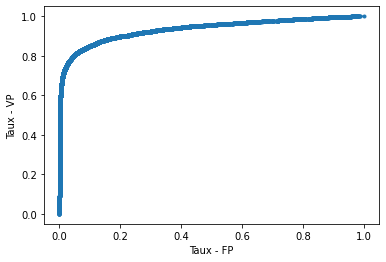

0.9348675789707477


In [ ]:
# Courbe ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
proba_positif_reglog =  reglog.predict_proba(XTest)
plt.figure()
fp, vp, _ = roc_curve(YTest, proba_positif_reglog[:,1])
plt.plot(fp, vp, marker='.')
plt.xlabel('Taux - FP')
plt.ylabel('Taux - VP')
plt.show()
# Affichage de l'aire sous la courbe
print(roc_auc_score(YTest, proba_positif_reglog[:,1]))

### 2.4 Arbre de décision



Dans cette partie, nous testons un modèle d'arbre de décision qui est une méthode supervisée. Ces algorithmes sélectionnent automatiquement les variables discriminantes à partir de données volumineuses. Ils peuvent ainsi permettre d'extraire des règles logiques de cause à effet (des déterminismes) qui n'apparaissaient pas initialement dans les données brutes

In [ ]:
# Arbre de décision
from sklearn.tree import DecisionTreeClassifier
arbreD = DecisionTreeClassifier(random_state=1)

In [ ]:
# Estimation sur les données d'apprentissage
arbreD.fit(XTrain,YTrain)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Prédiction sur les données de test
prediction_arbreD = arbreD.predict(XTest)

In [ ]:
# Matrice de confusion
from sklearn import metrics
matrice_confusion_arbreD = metrics.confusion_matrix(YTest,prediction_arbreD)
print(matrice_confusion_arbreD)

[[719274  11309]
 [  1967   4518]]


In [ ]:
# Calcul du f1 score
f1_score_arbreD = metrics.f1_score(YTest, prediction_arbreD)
print(f1_score_arbreD)

0.404983865184654


Nous obtenons une f1 mesure de 40% ce qui est notre meilleur résultat pour l'instant. 

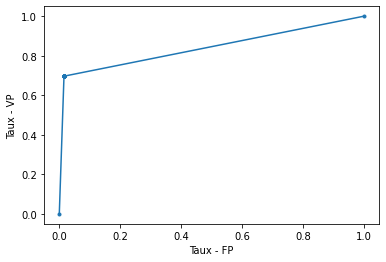

0.8406852673655709


In [ ]:
# Courbe ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
proba_positif_arbreD =  arbreD.predict_proba(XTest)
plt.figure()
fp, vp, _ = roc_curve(YTest, proba_positif_arbreD[:,1])
plt.plot(fp, vp, marker='.')
plt.xlabel('Taux - FP')
plt.ylabel('Taux - VP')
plt.show()
# Affichage de l'aire sous la courbe
print(roc_auc_score(YTest, proba_positif_arbreD[:,1]))

L'AUC score pour l'arbre de décision s'élève à 84,12%, ce qui signifie que le modèle classe les individus assez efficacement.

### 2.5 Analyse Discrimante Linéaire

Pour terminer, la dernière méthode choisie est l'Analyse Discriminante Linéaire sur les données standardisées et rééchantillonnées avec la méthode SMOTE. La méthode de l'analyse discriminante linéaire consiste, dans ce cas, à construire une fonction de classement (règle d’affectation, …) qui permet de prédire le groupe d’appartenance d’un individu à partir des valeurs prises par les variables prédictives. Elle repose sur un cadre probabiliste.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Instanciation du modèle
a_discri = LinearDiscriminantAnalysis()

In [ ]:
# Apprentissage du modèle sur les données d'apprentissage
modele_a_discri = a_discri.fit(XTrain,YTrain)

In [ ]:
# Prédiction sur les données test
prediction_a_discri = modele_a_discri.predict(XTest)

In [ ]:
# Affichage de la matrice de confusion
print(metrics.confusion_matrix(YTest,prediction_a_discri))
#Affichage du F1-score
print(metrics.f1_score(YTest,prediction_a_discri))

[[709761  20822]
 [  1540   4945]]
0.30664764975815456


Nous obtenons une f1 mesure de 30%.

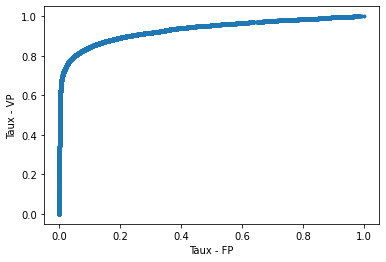

0.9325538188204023


In [ ]:
# Courbe ROC
from sklearn.metrics import roc_auc_score, roc_curve
plt.figure()
proba_positif_a_discri =  a_discri.predict_proba(XTest)
fp, vp, _ = roc_curve(YTest, proba_positif_a_discri[:,1])
plt.plot(fp, vp, marker='.')
plt.xlabel('Taux - FP')
plt.ylabel('Taux - VP')
plt.show()
#Affichage de l'aire sous la courbe
print(roc_auc_score(YTest, proba_positif_a_discri[:,1]))

Pour l'Analyse Discriminante Linéaire, nous avons une probabilité de 93,25% que la fonction SCORE place un positif devant un négatif. 

# 3 Comparaison des modèles

Pour terminer, nous allons faire une comparaison des modèles afin de voir lequel serait le meilleur.

In [ ]:
plt.figure()
fpxgBoost, vpxgBoost, _ = roc_curve(YTest, proba_positif_xgBoost[:,1])
plt.plot(fpxgBoost, vpxgBoost, marker='.')
fprl, vprl, _ = roc_curve(YTest, proba_positif_reglog[:,1])
plt.plot(fprl, vprl, marker='.')
fparbreD, vparbreD, _ = roc_curve(YTest, proba_positif_arbreD[:,1])
plt.plot(fparbreD, vparbreD, marker='.')
fpad, vpad, _ = roc_curve(YTest, proba_positif_a_discri[:,1])
plt.plot(fpad, vpad, marker='.')
plt.xlabel('Taux - FP')
plt.ylabel('Taux - VP')
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

Sur ce graphique comparant les courbes ROC des modèles (méthode des plus proches voisins exclue), nous remarquons que la courbe représentant l'arbre de décision est toujours en dessous des courbes représentant les autres modèles, qui elles se superposent. Il n'y a donc aucune situation où l'arbre de décision serait un meilleur modèle de prédiction que les autres.

# Conclusion

Pour conclure, nous pouvons dire que nous avons réalisé des étapes préliminaires avant de tester plusieurs modèles de prédiction. En effet, nous avons sélectionné les variables utiles à la prédiction, puis nous avons centré-réduit les variables explicatives et enfin, nous avons rééchantillonné nos données afin d'équilibrer les classes de la variable cible avec la méthode SMOTE. 

Après ces différentes étapes, nous avons pu tester plusieurs modèles de machine learning. Tout d'abord, nous avons séparé en données d'apprentissage et de test. Puis, nous avons décidé de réaliser un modèle de gradient boosting, un modèle de K plus proches voisins, une régression logistique, un arbre de décision et une analyse discriminante linéaire. Nous avons évalué nos modèles sur les données test, calculer la f1 mesure et fait une courbe ROC. Nous avons obtenu le meilleur modèle avec l'arbre de décision avec une f1 mesure de 0.4, cependant nous nous sommes aperçus qu'il s'agit également du pire modèle de préddiction en terme de AUC score et en visualisant le graphique comparant les courbes ROC des différents modèles.

Ce projet nous a permis de réaliser un travail complet sur des données réelles. Le volume des données était notre principale difficulté. De plus, nous étions face à des données déséquilibrées donc il fallait gérer ce problème de façon à obtenir des prédictions correctes. 

Pour aller plus loin, on aurait pu réaliser d'autres modèles de machine learning ou approfondir les modèles que nous avons fait. Par exemple, une recherche de paramètres optimaux aurait pu être utile mais le temps d'éxécution des programmes était très gourmand en temps.